<a href="https://colab.research.google.com/github/mlnzlk/3teck_GoogleColab_Study/blob/master/Transformer_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
# path 수정
path = "gdrive/My Drive/*"
os.listdir(path)

FileNotFoundError: ignored

# Data

http://www.manythings.org/anki/

같은 의미를 가진 언어/언어 데이터를 제공 하는 사이트 (영/한, 영/프, ...)

이중 영어/프랑스어 데이터 사용해볼 것


- 프랑스어: 입력 문장으로 사용
- 영어: 출력 문장으로 사용
- 위 입력/출력 데이터를 학습해서 번역 모델(기계번역기)을 만드는게 목표


In [ ]:
import pandas as pd
import numpy as np

## Data Load

In [ ]:
df = pd.read_csv(path + "fra.txt", names=['eng', 'fra', 'license'], sep='\t')
del df['license']
df

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.
...,...,...
194508,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
194509,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
194510,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
194511,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


## Preprocessing

In [ ]:
import unicodedata
import re

def unicode_to_ascii(sentence):
    return ''.join(w for w in unicodedata.normalize('NFD', sentence)
        if unicodedata.category(w) != 'Mn')

def preprocess_sentence(sentence):
    sentence = unicode_to_ascii(sentence.lower())
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)
    sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence)
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence

In [ ]:
# 연습용으로 30000만개만 사용
input_data = df[['fra', 'eng']][:30000].copy()
input_data

,fra,eng
0,Va !,Go.
1,Marche.,Go.
2,Bouge !,Go.
3,Salut !,Hi.
4,Salut.,Hi.
...,...,...
29995,Je veux une table basse.,I want a low table.
29996,Je veux une nouvelle robe.,I want a new dress.
29997,Je veux un nouveau couteau.,I want a new knife.
29998,Je veux un avocat.,I want an attorney.


In [ ]:
# 유니코드, 특수문자 제거
input_data['fra'] = input_data['fra'].apply(lambda x: preprocess_sentence(x))
input_data['eng'] = input_data['eng'].apply(lambda x: preprocess_sentence(x))


input_data

,fra,eng
0,va !,go .
1,marche .,go .
2,bouge !,go .
3,salut !,hi .
4,salut .,hi .
...,...,...
29995,je veux une table basse .,i want a low table .
29996,je veux une nouvelle robe .,i want a new dress .
29997,je veux un nouveau couteau .,i want a new knife .
29998,je veux un avocat .,i want an attorney .


## Make Vocabulary



### Source Language (Fra)

프랑스어 데이터로 tokenizer 학습 -> 프랑스어 vocab 생성

In [ ]:
import tensorflow_datasets as tfds

tokenizer_fra = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    input_data['fra'], target_vocab_size=2**13)

In [ ]:
vocab_size_fra = tokenizer_fra.vocab_size + 3  #  1 + 2 start/end
vocab_size_fra

7139

In [ ]:
tokenizer_fra.vocab_size # 7136

In [ ]:
encoder_start_token_id = tokenizer_fra.vocab_size
encoder_end_token_id = tokenizer_fra.vocab_size + 1  # encoder_start_token_id + 1

print(encoder_start_token_id)
print(encoder_end_token_id)

7136
7137


### Target Language (Eng)

영어 데이터로 tokenizer 학습 -> 영어 vocab 생성

In [ ]:
tokenizer_eng = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    input_data['eng'], target_vocab_size=2**13)

In [ ]:
vocab_size_eng = tokenizer_eng.vocab_size + 3
vocab_size_eng

5627

start/end token for decoder

In [ ]:
# 현재 token_id: 0 ~ 5623
tokenizer_eng.vocab_size

5624

In [ ]:
decoder_start_token_id = tokenizer_eng.vocab_size
decoder_end_token_id = tokenizer_eng.vocab_size + 1

print(decoder_start_token_id)
print(decoder_end_token_id)

5624
5625


### Subword Tokenization

In [ ]:
# integer encoding 예
tokenizer_eng.encode("yes it is")

[2251, 10, 682]

In [ ]:
# decoding 예
tokenizer_eng.decode([2253, 13, 685])

'yelled t girls '

In [ ]:
tokenizer_eng.encode("hello world run transformer")

[815, 2778, 5400, 388, 5484, 2424, 5483, 1775, 5469, 5482]

In [ ]:
tokenizer_eng.decode([815, 2778, 5400, 388, 5484, 2424, 5483, 1775, 5469, 5482])

'hello world run transformer'

In [ ]:
sentence = "hello world run transformer"
words = sentence.split()

for w in words:
    subwords = tokenizer_eng.encode(w)
    print(subwords, end='   ')

    for sw in subwords:
        print(tokenizer_eng.decode([sw]), end=' ')
    print()


[2560]   hello 
[2778]   world 
[305]   run 
[5484, 2424, 5483, 1775, 5469, 5482]   t ran s form e r 


## Train/Valid/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

trval_X_data, test_X_data, trval_y_data, test_y_data = train_test_split(
    input_data['fra'], input_data['eng'],
    test_size=100, shuffle=True, random_state=42)

In [ ]:
train_X_data, valid_X_data, train_y_data, valid_y_data = train_test_split(
    trval_X_data, trval_y_data, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_X_data

4589                        oubliez ca !
17426              consulte un medecin !
26424               tom est intolerant .
3251                       je me rends .
26803    nous ne pouvons pas aider tom .
                      ...               
26557       tom a commande de la pizza .
15621          ce n est pas ca l amour .
14636                      je vieillis .
9543                      vous pleurez ?
24562            je ne suis pas joueur .
Name: fra, Length: 23920, dtype: object

In [ ]:
train_X_data = np.array(train_X_data)
train_y_data = np.array(train_y_data)
valid_X_data = np.array(valid_X_data)
valid_y_data = np.array(valid_y_data)
test_X_data = np.array(test_X_data)
test_y_data = np.array(test_y_data)

In [ ]:
train_X_data

array(['oubliez ca !', 'consulte un medecin !', 'tom est intolerant .',
       ..., 'je vieillis .', 'vous pleurez ?', 'je ne suis pas joueur .'],
      dtype=object)

In [ ]:
print(len(train_X_data))
print(len(train_y_data))
print(len(valid_X_data))
print(len(valid_y_data))
print(len(test_X_data))
print(len(test_y_data))

NameError: ignored

## Model Input Data Prep.

- encoder인 RNN의 입력 형태
  - 프랑스어 문장이 input data임
  - "je suis étudiant"
- decoder인 RNN의 입력 형태
  - 처음 Step에 <start> 토큰만 주면 됨
    - (학습이 잘 되었다면 step1의 출력은 'I'가 될것)
  - step 2 입력이 'I'가 됨
    - (학습이 잘 되었다면 step2의 출력은 'am'이 될것)
  - RNN 출력이 <end>가 나오는 step에서 종료
  - Decoder로 생성된 최종문장의 예
    - "I is an student `<`end`>`"  (종료 토큰 포함됨)



모델 학습에 필요한 데이터를 정리하면,

- X
  - Encoder 입력을 위한 프랑스어 데이터
- y
  - Decoder 출력 영어 문장 (즉 모델이 예측한 Prediction_y값)이 잘 만들어졌는지 확인하기 위한
  - 정답 영어문장 + `<`end`>`


### Teacher Forcing Data

학습 중 decoder는 아직 성능이 안좋음
- 각 step에서 예측하는 단어가 원래 정답과 다를 확률이 크다

따라서 학습 단계에서는
- 이전 step에서 출력한 예측 단어를 입력으로 사용하지 말고
- 원래 정답 단어를 넣어줘서 학습을 더 잘하게 하자
- decoder_inputs도 X 데이터에 포함해 넣어준다!


## Integer Encoding

In [ ]:
train_X_data[0]

'oubliez ca !'

In [ ]:
tokenizer_fra.encode(train_X_data[0])

[599, 53, 6]

In [ ]:
# start/end token 추가
[encoder_start_token_id] + tokenizer_fra.encode(train_X_data[0]) + [encoder_end_token_id]

[7136, 599, 53, 6, 7137]

In [ ]:
train_encoder_inputs = []

for sentence in train_X_data:
    train_encoder_inputs.append([encoder_start_token_id] + tokenizer_fra.encode(sentence) + [encoder_end_token_id])

train_encoder_inputs[:5]

[[7136, 599, 53, 6, 7137],
 [7136, 2410, 4382, 333, 21, 466, 6, 7137],
 [7136, 7, 3, 2262, 5260, 2638, 6996, 1, 7137],
 [7136, 2, 26, 4818, 1, 7137],
 [7136, 12, 17, 164, 15, 2036, 44, 1, 7137]]

In [ ]:
valid_encoder_inputs = []
test_encoder_inputs = []

for sentence in valid_X_data:
    valid_encoder_inputs.append([encoder_start_token_id] + tokenizer_fra.encode(sentence) + [encoder_end_token_id])

for sentence in test_X_data:
    test_encoder_inputs.append([encoder_start_token_id] + tokenizer_fra.encode(sentence) + [encoder_end_token_id])


In [ ]:
# 레이블 데이터 (영어 <end> 토큰만 있음)
train_decoder_outputs = []
valid_decoder_outputs = []
test_decoder_outputs = []

for sentence in train_y_data:
    train_decoder_outputs.append(tokenizer_eng.encode(sentence) + [decoder_end_token_id])

for sentence in valid_y_data:
    valid_decoder_outputs.append(tokenizer_eng.encode(sentence) + [decoder_end_token_id])

for sentence in test_y_data:
    test_decoder_outputs.append(tokenizer_eng.encode(sentence) + [decoder_end_token_id])

train_decoder_outputs[:5]

[[29, 13, 1141, 1, 5625],
 [5071, 7, 425, 1, 5625],
 [5, 8, 4617, 1, 5625],
 [2, 2905, 1, 5625],
 [11, 24, 13, 100, 49, 1, 5625]]

In [ ]:
# Teacher Forcing 데이터 (영어 <start> 토큰만 있음)
train_decoder_inputs = []
valid_decoder_inputs = []
test_decoder_inputs = []

for sentence in train_y_data:
    train_decoder_inputs.append([decoder_start_token_id] + tokenizer_eng.encode(sentence))

for sentence in valid_y_data:
    valid_decoder_inputs.append([decoder_start_token_id] + tokenizer_eng.encode(sentence))

for sentence in test_y_data:
    test_decoder_inputs.append([decoder_start_token_id] + tokenizer_eng.encode(sentence))

train_decoder_inputs[:5]

[[5624, 29, 13, 1141, 1],
 [5624, 5071, 7, 425, 1],
 [5624, 5, 8, 4617, 1],
 [5624, 2, 2905, 1],
 [5624, 11, 24, 13, 100, 49, 1]]

## Check Sequence Length

max length 18
avg length 7.2257107023411375


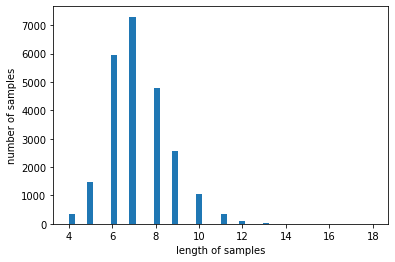

In [ ]:
import matplotlib.pyplot as plt

print(f"max length {max(len(l) for l in train_encoder_inputs)}")
print(f"avg length {(sum(map(len, train_encoder_inputs))/len(train_encoder_inputs))}")
plt.hist([len(s) for s in train_encoder_inputs], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_seq_len_fra = 16

max length 8
avg length 5.476254180602007


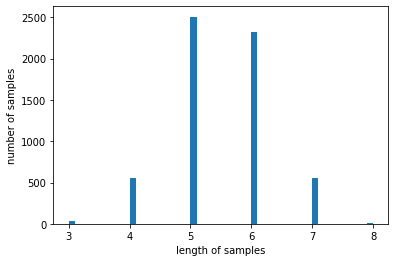

In [ ]:
import matplotlib.pyplot as plt

print(f"max length {max(len(l) for l in valid_decoder_outputs)}")
print(f"avg length {(sum(map(len, valid_decoder_outputs))/len(valid_decoder_outputs))}")
plt.hist([len(s) for s in valid_decoder_outputs], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_seq_len_eng = 16

In [ ]:
max_seq_len = 16

## Padding

In [ ]:
from keras.preprocessing.sequence import pad_sequences

train_encoder_inputs = pad_sequences(train_encoder_inputs, maxlen=max_seq_len, padding='post', truncating='post')
valid_encoder_inputs = pad_sequences(valid_encoder_inputs, maxlen=max_seq_len, padding='post', truncating='post')
test_encoder_inputs = pad_sequences(test_encoder_inputs, maxlen=max_seq_len, padding='post', truncating='post')

In [ ]:
print(train_encoder_inputs.shape)
print(valid_encoder_inputs.shape)
print(test_encoder_inputs.shape)

(23920, 16)
(5980, 16)
(100, 16)


In [ ]:
train_encoder_inputs[:5]

array([[7136,  599,   53,    6, 7137,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [7136, 2410, 4382,  333,   21,  466,    6, 7137,    0,    0,    0,
           0,    0,    0,    0,    0],
       [7136,    7,    3, 2262, 5260, 2638, 6996,    1, 7137,    0,    0,
           0,    0,    0,    0,    0],
       [7136,    2,   26, 4818,    1, 7137,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [7136,   12,   17,  164,   15, 2036,   44,    1, 7137,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
train_decoder_inputs = pad_sequences(train_decoder_inputs, maxlen=max_seq_len, padding='post', truncating='post')
valid_decoder_inputs = pad_sequences(valid_decoder_inputs, maxlen=max_seq_len, padding='post', truncating='post')
test_decoder_inputs = pad_sequences(test_decoder_inputs, maxlen=max_seq_len, padding='post', truncating='post')

print(train_decoder_inputs.shape)
print(valid_decoder_inputs.shape)
print(test_decoder_inputs.shape)

(23920, 16)
(5980, 16)
(100, 16)


In [ ]:
train_decoder_outputs = pad_sequences(train_decoder_outputs, maxlen=max_seq_len, padding='post', truncating='post')
valid_decoder_outputs = pad_sequences(valid_decoder_outputs, maxlen=max_seq_len, padding='post', truncating='post')
test_decoder_outputs = pad_sequences(test_decoder_outputs, maxlen=max_seq_len, padding='post', truncating='post')

print(train_decoder_outputs.shape)
print(valid_decoder_outputs.shape)
print(test_decoder_outputs.shape)

(23920, 16)
(5980, 16)
(100, 16)


## Model Input Data

In [ ]:
train_X = [train_encoder_inputs, train_decoder_inputs]
valid_X = [valid_encoder_inputs, valid_decoder_inputs]
test_X = test_encoder_inputs  # test 할때는 Teacher Forcing 안함

In [ ]:
train_y = train_decoder_outputs
valid_y = valid_decoder_outputs
test_y = test_decoder_outputs

# Model: Transformer

## Model

In [ ]:
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention,
                                        (batch_size, -1, self.d_model))
        outputs = self.dense(concat_attention)
        return outputs

In [ ]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [ ]:
def transformer(encode_vocab_size, decode_vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):

    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=encode_vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=decode_vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=decode_vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2 # 6
D_MODEL = 256  # 512
NUM_HEADS = 8  # 8
UNITS = 512    # 2048 dff의 크기
DROPOUT = 0.1

model = transformer(
    encode_vocab_size=vocab_size_fra,
    decode_vocab_size=vocab_size_eng,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, max_seq_len))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, max_seq_len))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## Train

In [ ]:
batch_size = 32
n_epochs = 50
hist = model.fit(train_X, train_y, validation_data=(valid_X, valid_y), batch_size=batch_size, epochs=n_epochs)

Epoch 1/50
748/748 [==============================] - 35s 34ms/step - loss: 1.6911 - accuracy: 0.1328 - val_loss: 0.9936 - val_accuracy: 0.1932
Epoch 2/50
748/748 [==============================] - 24s 32ms/step - loss: 0.8396 - accuracy: 0.2135 - val_loss: 0.7099 - val_accuracy: 0.2285
Epoch 3/50
748/748 [==============================] - 24s 32ms/step - loss: 0.6201 - accuracy: 0.2405 - val_loss: 0.5610 - val_accuracy: 0.2501
Epoch 4/50
748/748 [==============================] - 24s 32ms/step - loss: 0.4767 - accuracy: 0.2606 - val_loss: 0.4638 - val_accuracy: 0.2628
Epoch 5/50
748/748 [==============================] - 25s 33ms/step - loss: 0.3903 - accuracy: 0.2728 - val_loss: 0.4425 - val_accuracy: 0.2671
Epoch 6/50
748/748 [==============================] - 24s 33ms/step - loss: 0.3406 - accuracy: 0.2795 - val_loss: 0.4132 - val_accuracy: 0.2721
Epoch 7/50
748/748 [==============================] - 24s 32ms/step - loss: 0.2912 - accuracy: 0.2875 - val_loss: 0.3968 - val_accuracy:

<function matplotlib.pyplot.show>

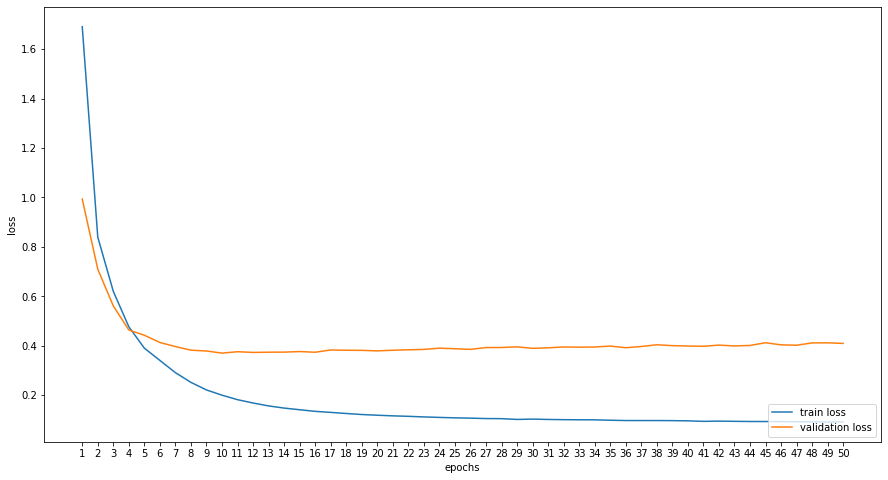

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 8))
ax = plt.axes()
ax.set_xticks(np.arange(0, n_epochs, 1))
ax.set_xticklabels(np.arange(1, n_epochs + 1, 1))
plt.plot(hist.history['loss'], label = 'train loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.xticks(np.arange(0, n_epochs, 1))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 'lower right')
plt.show

<function matplotlib.pyplot.show>

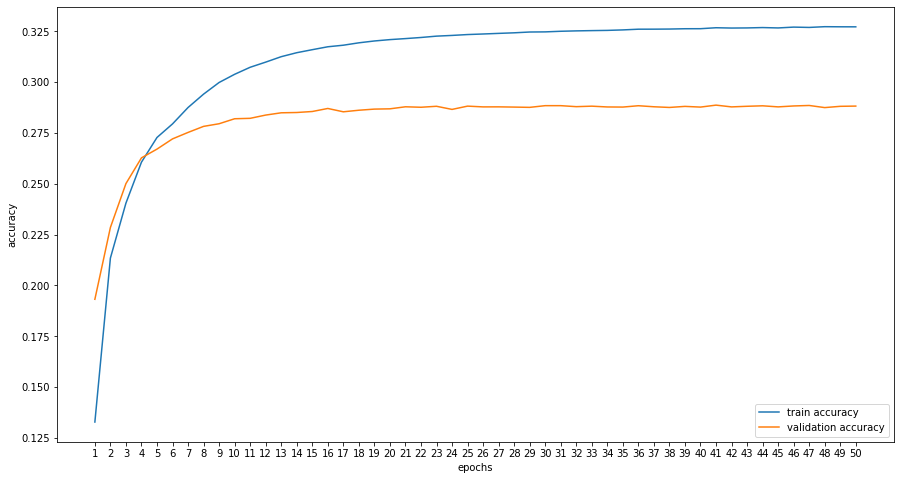

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
ax = plt.axes()
ax.set_xticks(np.arange(0, n_epochs, 1))
ax.set_xticklabels(np.arange(1, n_epochs + 1, 1))
plt.plot(hist.history['accuracy'], label = 'train accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.xticks(np.arange(0, n_epochs, 1))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.show

## Prediction

In [ ]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

def translaion_using_model(encoder_input):
    # 디코더 인풋은 영어 문장의 시작 토큰만 들어감
    decoder_input = [decoder_start_token_id]
    output = tf.expand_dims(decoder_input, 0)

    decoded_sentence = ''
    for i in range(50):
        predictions = model(inputs=[[encoder_input], output], training=False)

        # 예측 결과 중 마지막 부분 추출
        predictions = predictions[:,-1:, :]  # (batch_size, 1, vocab_size)

        output_token_id = np.argmax(predictions, axis=-1)[0][0]

        # end token -> prediction 종료
        if output_token_id == decoder_end_token_id:
            break

        output_word = tokenizer_eng.decode([output_token_id])
        decoded_sentence += ' ' + output_word

        # 이전단어 + 예측한 단어  --> 다음 Prediction의 입력으로 사용
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        output = tf.concat([output, predicted_id], axis=-1)

    return decoded_sentence

In [ ]:
def test_translate(inp_sentence):
    inp_sentence = preprocess_sentence(inp_sentence)
    inp_sentence = [encoder_start_token_id] + tokenizer_fra.encode(inp_sentence) + [encoder_end_token_id]
    inp_sentence = pad_sequences([inp_sentence], maxlen=max_seq_len, padding='post', truncating='post')
    encoder_input = inp_sentence

    return translaion_using_model(encoder_input)

In [ ]:
test_translate("oubliez ca !")  # don t bother .

' forget  it  !'

### BELU Score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from tqdm import tqdm

references = []
candidates = []
for sentence, reference in zip(tqdm(test_X), test_y_data):
    sentence = tf.expand_dims(sentence, 0)

    candidate = translaion_using_model(sentence)
    candidate = candidate.split()
    #candidate.remove('<end>') if '<end>' in candidate else None
    candidates.append(candidate)

    reference = reference.split()
    #reference.remove('<start>')
    #reference.remove('<end>')
    references.append(reference)

smoothing_function = SmoothingFunction(epsilon=0.1).method1  # epsilon=1e-12
bleu_score1 = corpus_bleu(references, candidates, smoothing_function=smoothing_function, weights=(1.0, 0, 0, 0))
bleu_score2 = corpus_bleu(references, candidates, smoothing_function=smoothing_function, weights=(0.5, 0.5, 0, 0))
bleu_score3 = corpus_bleu(references, candidates, smoothing_function=smoothing_function, weights=(0.34, 0.33, 0.33, 0))
bleu_score4 = corpus_bleu(references, candidates, smoothing_function=smoothing_function, weights=(0.25, 0.25, 0.25, 0.25))

print("\n\n")
print(f"BLEU1 SCORE: {bleu_score1}")
print(f"BLEU2 SCORE: {bleu_score2}")
print(f"BLEU3 SCORE: {bleu_score3}")
print(f"BLEU4 SCORE: {bleu_score4}")

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]




BLEU1 SCORE: 0.26515151515151514
BLEU2 SCORE: 0.007870914088389136
BLEU3 SCORE: 0.0027885162923520458
BLEU4 SCORE: 0.0016873498796154212
